# Proyección de ventas de bebidas alcoholicas 1 año a futuro

fuente: https://www.kaggle.com/namanmanchanda/rnn-in-pytorch/notebook

datos: https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting/version/6

fuente original datos: https://fred.stlouisfed.org/series/S4248SM144NCEN



In [168]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [169]:
df = pd.read_csv("/content/drive/My Drive/CIA_marcos/deep_learning/clase_6/Alcohol_Sales.csv", index_col = 0, parse_dates = True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [170]:
df.dropna(inplace=True)
len(df)

325

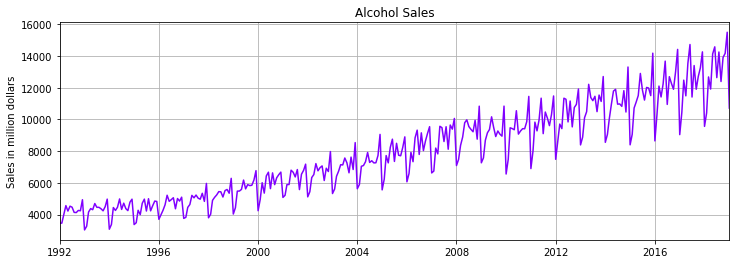

In [171]:
# visualización de datos
plt.figure(figsize = (12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'],color='#8000ff')
plt.show()

In [209]:
# extracting the time series values
y = df['S4248SM144NCEN'].values.astype(float) 

#defining a test size (los últimos 12 meses para el test final)
test_size = 12

#create train and test splits
train_set = y[:-test_size]
test_set = y[-test_size:]

print(len(test_set))


12


In [210]:
# normalización de datos
from sklearn.preprocessing import MinMaxScaler

# instantiate a scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))


In [211]:
# convert train_norm to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# define a window size
# aca se define el número de muestras que se utilizan para predecir (como entrada)
# cuantos datos del pasado tomo como referencia para estimar el siguiente
window_size = 12

# define a function to create sequence/label tuples
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws): 
        window = seq[i:i+ws]# barro el 'seq' desde el inicio, con un largo de ws
        label = seq[i+ws:i+ws+1] # saco el 'label' siguiente, correspondiente al valor del siguiente año
        out.append((window,label)) # unifico en una list los inputs y el label
    return out

# apply input_data to train_norm
train_data = input_data(train_norm, window_size)
print('número de datos para entrenar [input, label]: ', len(train_data))
print('por ejemplo, el primero: ')
print(train_data[0])


número de datos para entrenar [input, label]:  301
por ejemplo, el primero: 
(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))


Defino mi RNN con LSTM

In [212]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]


In [222]:
torch.manual_seed(42)

# instantiate
model = LSTMnetwork(input_size=1, hidden_size=150,  output_size=1)

# loss
criterion = nn.MSELoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [ ]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.36364824
Epoch:  2 Loss: 0.19895600
Epoch:  3 Loss: 0.34702995
Epoch:  4 Loss: 0.44128731
Epoch:  5 Loss: 0.32852632
Epoch:  6 Loss: 0.34353352
Epoch:  7 Loss: 0.31768239
Epoch:  8 Loss: 0.24758968
Epoch:  9 Loss: 0.29078937
Epoch: 10 Loss: 0.37820294
Epoch: 11 Loss: 0.35211805
Epoch: 12 Loss: 0.32350418
Epoch: 13 Loss: 0.34103331
Epoch: 14 Loss: 0.21384671
Epoch: 15 Loss: 0.30165651
Epoch: 16 Loss: 0.07724445
Epoch: 17 Loss: 0.00938648
Epoch: 18 Loss: 0.01076413
Epoch: 19 Loss: 0.00466263
Epoch: 20 Loss: 0.00022544
Epoch: 21 Loss: 0.01187396
Epoch: 22 Loss: 0.00768727
Epoch: 23 Loss: 0.00354872
Epoch: 24 Loss: 0.00333304
Epoch: 25 Loss: 0.00002838
Epoch: 26 Loss: 0.00388483
Epoch: 27 Loss: 0.00032606
Epoch: 28 Loss: 0.00238833
Epoch: 29 Loss: 0.00279411
Epoch: 30 Loss: 0.00316156
Epoch: 31 Loss: 0.00572133
Epoch: 32 Loss: 0.00049990
Epoch: 33 Loss: 0.02282726
Epoch: 34 Loss: 0.03082117
Epoch: 35 Loss: 0.00710028
Epoch: 36 Loss: 0.01629894
Epoch: 37 Loss: 0.00995763
E

Veamos una predicción a futuro de 12 meses (12 muestras)

In [218]:
future = 12 # para fijar cuantos datos a futuro voy a iterar

# tomo los últimos window_size meses, acorde al entrenamiento del modelo
preds = train_norm[-window_size:].tolist()
print('largo input: ', len(preds))


model.eval()
# armo for loop para ir agregando la última predicción y la uso para predecir el futuro
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        salida = model(seq).item()
        preds.append(salida) # acá estoy cargando la última predicción
print('largo últimos predecidos: ', len(preds[-future:]))



largo input:  12
largo últimos predecidos:  12


In [219]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [220]:
true_predictions = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))
print(true_predictions)

# calculo de error de lo predecido vs el último mes no usado en el entrenamiento
pred_f = torch.FloatTensor(true_predictions)
test_norm = df['S4248SM144NCEN'][-12:].to_numpy()
test_norm = torch.FloatTensor(test_norm)
loss = criterion(pred_f.squeeze(), test_norm.squeeze())
print('MSE : ', torch.sqrt(loss).item())

[[11416.73830378]
 [12329.00937647]
 [12089.16378802]
 [13376.24885485]
 [14713.68841362]
 [11437.84044242]
 [13740.18648234]
 [12052.39751974]
 [12787.36830086]
 [13223.96821612]
 [14367.50895193]
 [10570.34081122]]
MSE :  767.6104736328125


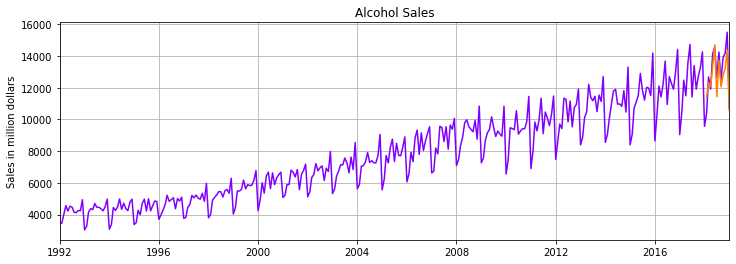

In [221]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()

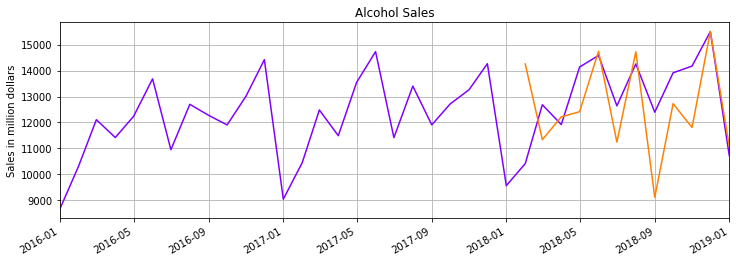

In [208]:
fig = plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2016-01-01':], color='#8000ff')
plt.plot(x,true_predictions, color='#ff8000')
plt.show()